In [1]:
# import packages
import pandas as pd # manipuler les dataFrames
import os # interargir avec le systeme de fichier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split # spliter son dataset
from sklearn.tree import DecisionTreeClassifier # loding Estimateur
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score # evaluation
from sklearn.preprocessing import StandardScaler # normalisation, moy et sd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import warnings # ignorer les avertissements
warnings.filterwarnings('ignore')

In [2]:
# loading dataset
os.chdir('C:/Users/Simplonco/Documents/jupyter-notebook/datasets/')
data = pd.read_csv('Dataset.csv',na_values='Unknown' ,sep=';')
pd.set_option('display.max_columns', data.shape[0]+1) # wiew all columns on dataset
df = data.copy() # faire une copy du dataset
df.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


### Separation avant alitération

In [3]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

In [4]:
def description(df):
    return df.describe(), df.describe(include='object'), df.isnull().sum().sort_values(ascending=False)

In [5]:
a , b, c = description(df_train)

In [6]:
# Separations des variables quantitatives et qualitatives
def split_data(df):
    cat_data = []
    num_data = []
    for i,c in enumerate(df.dtypes):
        #df.dtypes
        if c==object:
            cat_data.append(df.iloc[:,i])
        else:
            num_data.append(df.iloc[:,i])

    return pd.DataFrame(cat_data).transpose(), pd.DataFrame(num_data).T

In [7]:
cat_data, num_data = split_data(df_train)
cat_data.isnull().sum().sort_values(ascending=False)
# pour les variables catégorielles, remplacer les
# valeurs manquantes par le mode
cat_data = cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
#cat_data.isnull().sum().any()
#cat_data.info()

In [8]:
def encoding_cat(df):
    # ordinal variable
    code = {'Existing Customer':1,
            'Attrited Customer':0,
            'Uneducated':0,
            'College':1,
            'High School':2,
            'Graduate':3,
            'Post-Graduate':4,
            'Doctorate':5,
            'Less than $40K':0,
            '$40K - $60K':1,
            '$80K - $120K':2,
            '$60K - $80K':3,
            '$120K +':4,
            'Blue':0,
            'Silver':1,
            'Gold':2,
            'Platinum':3
            }
    var = ['Attrition_Flag', 'Education_Level','Income_Category', 'Card_Category']
    for col in var:
        df.loc[:,col] = df[col].map(code)
        
    # nominal variable
    var_without_grad = ['Gender', 'Marital_Status']
    df_1 = df[var_without_grad]
    df_1 = pd.get_dummies(df_1, drop_first=True)
    df = df.drop(var_without_grad, axis='columns')

    df = pd.concat([df, df_1], axis='columns')
 
    return df

In [9]:
# variable categorielle
cat_data = encoding_cat(cat_data)

In [10]:
num_data.drop('CLIENTNUM', axis=1, inplace=True)

In [11]:
target = cat_data['Attrition_Flag']
cat_data.drop('Attrition_Flag', axis=1, inplace=True) 

In [12]:
df_train = pd.concat([cat_data, num_data, target], axis='columns')

EDA

In [13]:
# variable target
#'Existing Customer':1,
#'Attrited Customer':0,
X = df_train.drop('Attrition_Flag', axis=1) 
target = df_train['Attrition_Flag']

le pourcentage de compte fermé est: 0.8347911963882618
le pourcentage de compte ouvert est: 0.16520880361173815


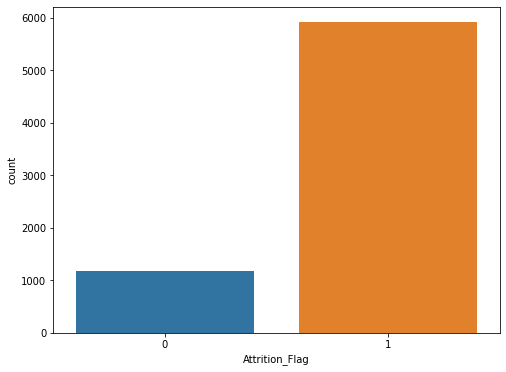

In [14]:
#target.value_counts()
plt.figure(figsize=(8,6))
sns.countplot(target)
no = target.value_counts()[0]/len(target)
yes = target.value_counts()[1]/len(target)
print(f'le pourcentage de compte fermé est: {yes}')
print(f'le pourcentage de compte ouvert est: {no}')

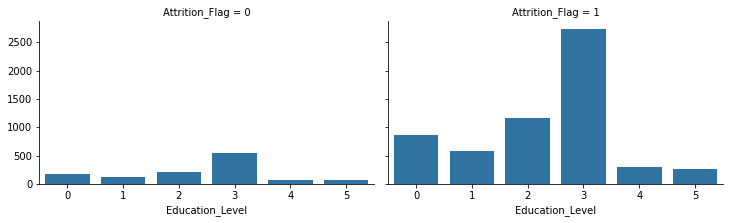

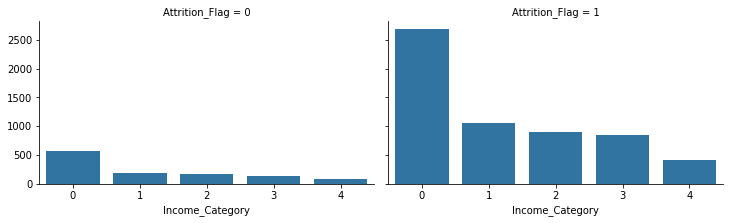

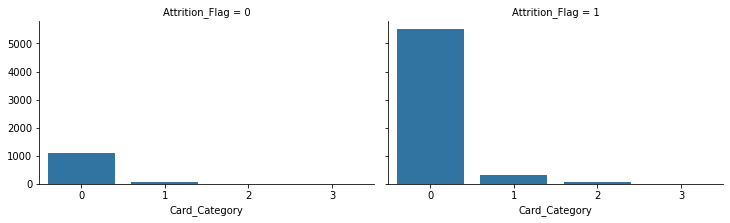

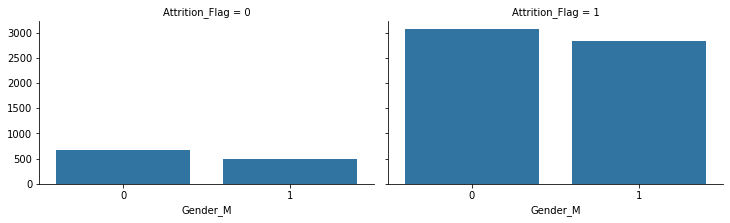

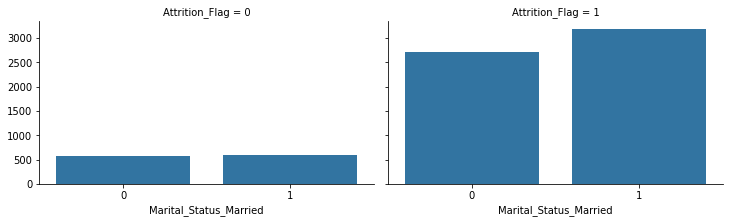

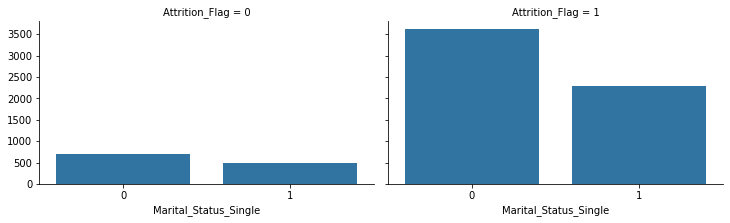

In [15]:
# selection des variables categorielles les plus pertinente
for col in cat_data:
    grid = sns.FacetGrid(df_train, col='Attrition_Flag', size=3.2, aspect=1.6)
    grid.map(sns.countplot, col)

In [16]:
df_train.groupby('Attrition_Flag').median()

,Education_Level,Income_Category,Card_Category,Gender_M,Marital_Status_Married,Marital_Status_Single,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Attrition_Flag,,,,,,,,,,,,,,,,,,,,
0,3,1,0,0,1,0,47.0,2.0,36.0,3.0,3.0,3.0,4085.0,0.0,3443.0,0.703,2325.0,43.0,0.524,0.000
1,3,1,0,0,1,0,46.0,2.0,36.0,4.0,2.0,2.0,4737.0,1373.0,3554.0,0.742,4092.0,71.0,0.725,0.211


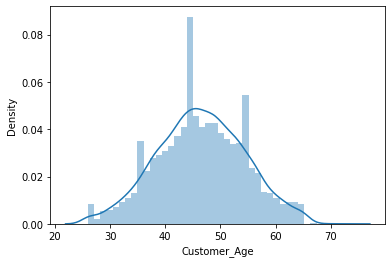

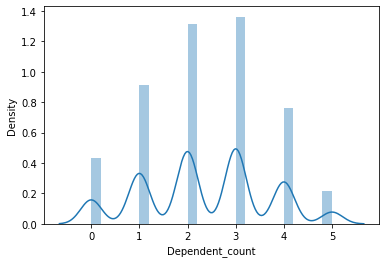

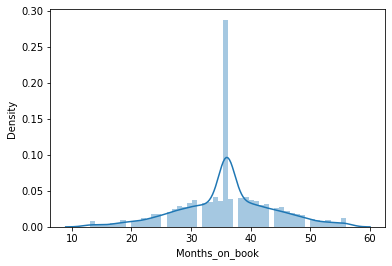

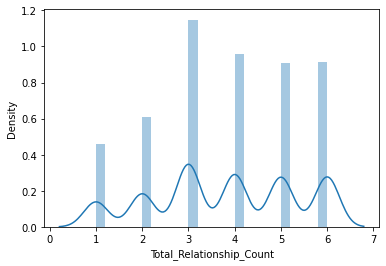

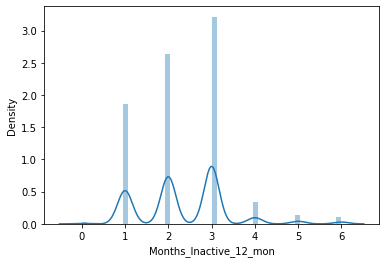

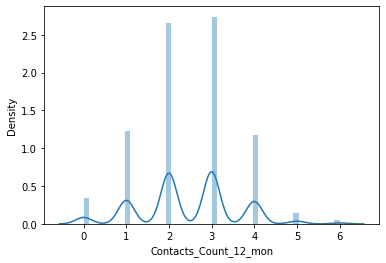

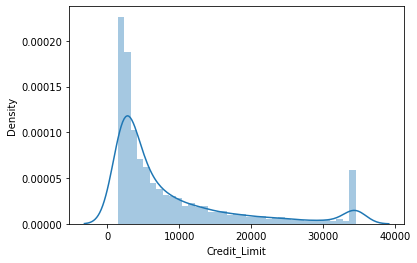

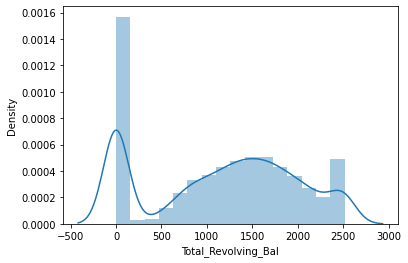

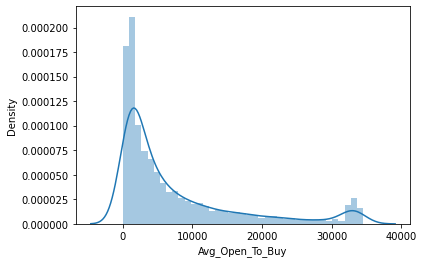

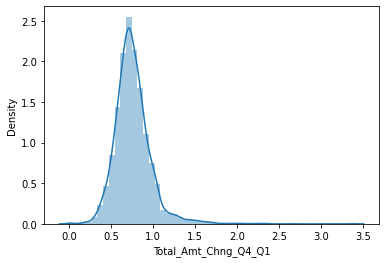

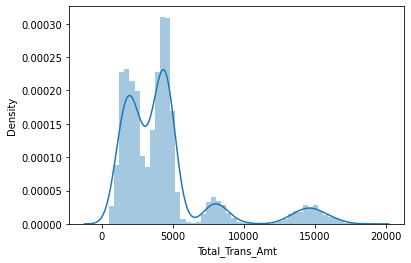

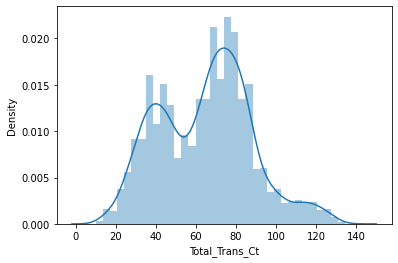

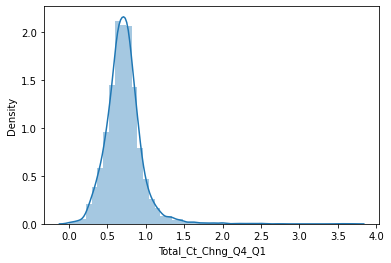

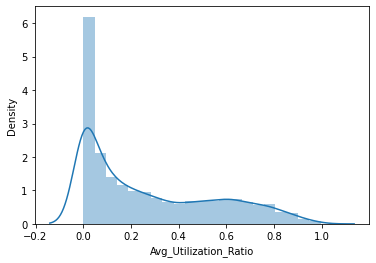

In [17]:
# normale et symétrique comme asymétrique
for col in num_data:
    plt.figure()
    sns.distplot(df_train[col])

les variables pertinentes : 

les variables catégorielles selectionnées sont: Education_level, Income_Category, Card_Caterory, Marital_Status.

les variables numériques selectionnées: Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct ,Avg_Utilization_Ratio

### Realisation des modeles

In [18]:
X_train = X
y_train = target

### transformation de X_test avant application dans le model

In [19]:
df_test.head(3)
cat_data, num_data = split_data(df_test)
cat_data = cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
cat_data = encoding_cat(cat_data)
num_data.drop('CLIENTNUM', axis=1, inplace=True)
target = cat_data['Attrition_Flag']
cat_data.drop('Attrition_Flag', axis=1, inplace=True)
df_test = pd.concat([cat_data, num_data, target], axis='columns')
X_test = df_test.drop('Attrition_Flag', axis=1) 
y_test = df_test['Attrition_Flag']

In [20]:
# chargement des models
models={
    'LogisticRegression': LogisticRegression(random_state=0),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=1, random_state=0),
    'RandomForestClassifier': RandomForestClassifier(random_state=0), 
    'AdaBoostClassifier': AdaBoostClassifier(random_state=0)
}

# La fonction de precision
def accu(y_true, y_pred, retu=False):
    acc = accuracy_score(y_true, y_pred)
    if retu:
        return acc
    else:
        print(f'la precision du models est : {acc}')

        
# la fonction d'application des modeles
def train_test_eval(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(name, ':')
        model.fit(X_train, y_train)
        accu(y_test, model.predict(X_test))
        print('-'*30)
        
        
# execution
train_test_eval(models, X_train, y_train, X_test, y_test)

LogisticRegression :
la precision du models est : 0.8963474827245804
------------------------------
KNeighborsClassifier :
la precision du models est : 0.8950312602829879
------------------------------
DecisionTreeClassifier :
la precision du models est : 0.8499506416584403
------------------------------
RandomForestClassifier :
la precision du models est : 0.9565646594274433
------------------------------
AdaBoostClassifier :
la precision du models est : 0.9575518262586377
------------------------------


In [21]:
# enregistrement du model en pickle
Classifier = AdaBoostClassifier()
Classifier.fit(X_train, y_train)
pickle.dump(Classifier, open('model.pkl','wb'))

### Construction d'un modele avec les variables selectionnées
les variables catégorielles selectionnées sont: Education_level, Income_Category, Card_Caterory

les variables numériques selectionnées: Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct ,Avg_Utilization_Ratio


In [22]:
data.head(1)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061


In [23]:
df1_train = pd.concat([X_train, y_train], axis=1)
df1_test = pd.concat([X_test, y_test], axis=1)
df1_train = df1_train[['Education_Level', 'Income_Category', 'Card_Category', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct' ,'Avg_Utilization_Ratio','Attrition_Flag']]
df1_test = df1_test[['Education_Level', 'Income_Category', 'Card_Category', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct' ,'Avg_Utilization_Ratio','Attrition_Flag']]
X_train = df1_train.drop('Attrition_Flag', axis='columns')
y_train = df1_train['Attrition_Flag']
X_test = df1_test.drop('Attrition_Flag', axis='columns')
y_test = df1_test['Attrition_Flag']

In [24]:
# execution
train_test_eval(models, X_train, y_train, X_test, y_test)

LogisticRegression :
la precision du models est : 0.8769332017110891
------------------------------
KNeighborsClassifier :
la precision du models est : 0.9032576505429417
------------------------------
DecisionTreeClassifier :
la precision du models est : 0.8499506416584403
------------------------------
RandomForestClassifier :
la precision du models est : 0.9272787101020072
------------------------------
AdaBoostClassifier :
la precision du models est : 0.9315564330371833
------------------------------


In [25]:
# enregistrement du model en pickle
Classifier = AdaBoostClassifier()
Classifier.fit(X_train, y_train)
pickle.dump(Classifier, open('model.pkl','wb'))